In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import random
import os
from PIL import Image

from torchvision.models import vgg16, resnet50, ResNet50_Weights, VGG16_Weights

from torchvision import transforms

import torch
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, v2
#from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
datasets.CIFAR10.classes()

AttributeError: type object 'CIFAR10' has no attribute 'classes'

In [15]:
d =datasets.FGVCAircraft(root='./FGVC', annotation_level='family', download=True, transform = ToTensor())
l = [d[i][1] for i in range(len(d))]

unique_classes = sorted(set(l))
unique_classes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69]

12


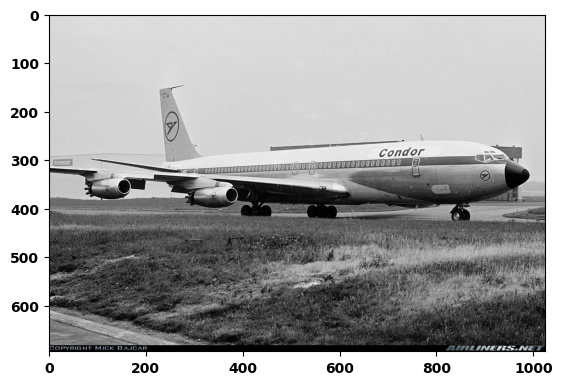

In [19]:
for i, j in d:
    
    plt.imshow(d[0][0].permute(1, 2, 0))

    print(d[0][1])
    break

25


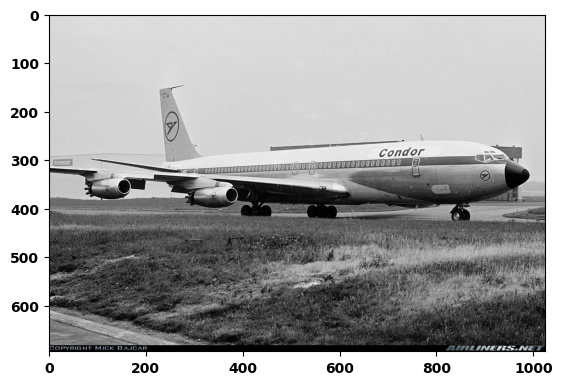

In [14]:
for k,v in FGVCManufacturerDataset(data_root, split='trainval'):
    plt.imshow(k)
    print(v)
    break

In [12]:
class AircraftCNNManual(nn.Module):
    def __init__(self, num_classes):
        super(AircraftCNNManual, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.relu_fc1 = nn.ReLU()
        self.drop_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.drop1(self.pool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.drop2(self.pool2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.drop3(self.pool3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.drop4(self.pool4(self.relu4(self.bn4(self.conv4(x)))))

        x = x.view(x.size(0), -1)
        x = self.drop_fc1(self.relu_fc1(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



In [13]:
# 1. CONFIG & UTILITIES  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_dataloaders(name, batch_size=64):#, root="data/"):
    """
    name: one of "cifar10","fashionmnist","fgvc_aircraft","imagenet"
    returns train_loader, val_loader, num_classes, class_names, img_size
    """
    if name == "CIFAR10":
        num_classes = 10
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #datasets.CIFAR10.classes

        img_size = 32
        ds_cls = datasets.CIFAR10
        train_tf = v2.Compose([
            v2.RandomHorizontalFlip(),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize( mean=[0.491,0.482,0.447], std=[0.247,0.243,0.262] )
        ])
        test_tf = v2.Compose([ v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize( mean=[0.491,0.482,0.447], std=[0.247,0.243,0.262] )
        ])
        # **NOTE**: CIFAR uses train=True/False, _not_ split="…"
        train_ds = ds_cls(root=f"./{name}", train=True,  download=True, transform=train_tf)
        val_ds   = ds_cls(root=f"./{name}", train=False, download=True, transform=test_tf)
    elif name == "FashionMNIST":
        num_classes = 10
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] #datasets.FashionMNIST.classes
        img_size = 28
        ds_cls = datasets.FashionMNIST
        train_tf = v2.Compose([
            v2.RandomCrop(28, padding=4),
            v2.ToTensor(),
            v2.Normalize( mean=[0.286], std=[0.353] )
        ])
        test_tf = v2.Compose([
            v2.ToTensor(),
            v2.Normalize( mean=[0.286], std=[0.353] )
        ])
        # **NOTE**: FashionMNIST also uses train=True/False
        train_ds = ds_cls(root=f"./{name}", train=True,  download=True, transform=train_tf)
        val_ds   = ds_cls(root=f"./{name}", train=False, download=True, transform=test_tf)
    elif name == "FGVC":
        # num_classes = 100
        # you need to download FGVC-Aircraft manually into root
        # class_names = None
        img_size = 224
        # ds_cls = datasets.FGVCAircraft
        train_tf = v2.Compose([
            v2.RandomResizedCrop(224),
            v2.RandomHorizontalFlip(),
            v2.ToTensor(),
            v2.Normalize( mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225] )
        ])
        test_tf = v2.Compose([
            v2.Resize(256),
            v2.CenterCrop(224),
            v2.ToTensor(),
            v2.Normalize( mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225] )
        ])
        # **NOTE**: FGVC-Aircraft uses split="train"/"test"
        
        # train_ds = ds_cls(root=f"./{name}", split="train", download=True, transform=train_tf)
        # val_ds   = ds_cls(root=f"./{name}", split="test",  download=True, transform=test_tf)
        train_ds = FGVCManufacturerDataset(root_dir='FGVC/fgvc-aircraft-2013b/data', split='trainval', transform=train_tf)
        val_ds   = FGVCManufacturerDataset(root_dir='FGVC/fgvc-aircraft-2013b/data', split='test', transform=test_tf)
        num_classes = len(train_ds.label_map)
        #model = AircraftCNNManual(num_classes).to(device)
    elif name == "ImageNet":
        num_classes = 1000
        #class_names = None  # fill from your synset txt
        img_size = 224
        ds_cls = datasets.ImageNet
        train_tf = v2.Compose([
            v2.Resize(256),
            v2.RandomCrop(224),
            v2.RandomHorizontalFlip(),
            v2.ToTensor(),
            v2.Normalize( mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225] )
        ])
        test_tf = v2.Compose([
            v2.Resize(224),
            v2.ToTensor(),
            v2.Normalize( mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225] )
        ])
        # **NOTE**: ImageNet uses split="train"/"val"
        train_ds = ds_cls(root=f"./{name}", split="train", download=True, transform=train_tf)
        val_ds   = ds_cls(root=f"./{name}", split="val",   download=True, transform=test_tf)
    else:
        raise ValueError(f"Unknown dataset {name}")

    # train_ds = ds_cls(root=f"./{name}", split="train", download=True, transform=train_tf)
    # val_ds   = ds_cls(root=f"./{name}", split="test",  download=True, transform=test_tf)
    # robustly grab class names
    if hasattr(train_ds, "classes"):
        class_names = train_ds.classes
    elif hasattr(train_ds, "class_to_idx"):
        # invert the dict so we get idx→name in order
        class_names = [k for k, _ in sorted(train_ds.class_to_idx.items(), key=lambda x: x[1])]
    else:
        class_names = [k for k,v in train_ds.label_map.items()]
    return ( DataLoader(train_ds, batch_size, shuffle=True,  num_workers=4, pin_memory=True),
             DataLoader(val_ds,   batch_size, shuffle=False, num_workers=4, pin_memory=True),
             num_classes, class_names, img_size )

In [14]:
def build_model(base="resnet50", num_classes=10, pretrained=True):
    if base=="resnet50":
        m = resnet50(weights=ResNet50_Weights.DEFAULT)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    elif base=="vgg16":
        m = vgg16(weights=VGG16_Weights.DEFAULT)
        m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    elif base=="cnn":
        m = model = AircraftCNNManual(num_classes)
    else:
        raise ValueError("only resnet50/vgg16/cnn")
    return m.to(device)

In [15]:
# 2. TRAIN/VALID LOOP WITH METRICS
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate(model, loader):
    model.eval()
    ys, yps = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(1).cpu()
            yps.extend(preds.tolist())
            ys.extend(y.tolist())
    acc = accuracy_score(ys, yps)
    p, r, f1, _ = precision_recall_fscore_support(ys, yps, average='weighted', zero_division=0)
    return acc, p, r, f1

In [16]:
# 3. KICK OFF TRAINING
def run_training(dataset="CIFAR10", model_base="resnet50", epochs=5, bs=64, lr=1e-3):
    train_loader, val_loader, nc, class_names, img_sz = make_dataloaders(dataset, bs)
    model     = build_model(model_base, nc)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        train_one_epoch(model, train_loader, optimizer, criterion)
        acc,p,r,f1 = evaluate(model, val_loader)
        print(f"[{dataset}][{model_base}] Epoch {epoch:02d} → "
              f"Acc={acc:.4f}  P={p:.4f}  R={r:.4f}  F1={f1:.4f}")
    return model, class_names

# 4. VISUALIZE 10 RANDOM WITH PRED VS TRUE
def show_random_preds(model, dataset_name, class_names=None, n=10):
    _, val_loader, nc, _, img_sz = make_dataloaders(dataset_name, batch_size=1)
    # collect all indices
    ds = val_loader.dataset
    idxs = random.sample(range(len(ds)), n)
    plt.figure(figsize=(15,4))
    for i, idx in enumerate(idxs):
        img, label = ds[idx]
        inp = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(inp).argmax(1).item()
        ax = plt.subplot(2, n//2, i+1)
        # undo norm for display
        img_disp = img.cpu().permute(1,2,0).clip(0,1)
        ax.imshow(img_disp)
        true_lbl = class_names[label] if class_names else str(label)
        pred_lbl = class_names[pred] if class_names else str(pred)
        ax.set_title(f"T:{true_lbl}\nP:{pred_lbl}")
        ax.axis('off')
    plt.show()

In [ ]:
# EXAMPLE USAGE
if __name__=="__main__":
    # Fine-tune ResNet50 on CIFAR-10 for 3 epochs
    model, names = run_training("FGVC","resnet50", epochs=3, bs=128, lr=1e-3)
    show_random_preds(model, "FGVC", class_names=names, n=10)

In [ ]:
train_tf = v2.Compose([
  v2.RandAugment(num_ops=2, magnitude=9),    # simpler, no policy search
  v2.ToTensor(),
  v2.Normalize(...)
])
# or
train_tf = v2.Compose([
  v2.AutoAugment(policy=AutoAugment.Policy.IMAGENET),
  v2.ToTensor(),
  v2.Normalize(...)
])

In [18]:


class FGVCManufacturerDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Path to 'fgvc-aircraft-2013b/data'
            split (str): One of 'train', 'val', or 'test'
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Load split-specific manufacturer file
        label_file = os.path.join(root_dir, f"images_manufacturer_{split}.txt")
        with open(label_file, 'r') as f:
            lines = [line.strip().split() for line in f.readlines()]
            self.samples = [(img_id, " ".join(parts[0:])) for img_id, *parts in lines]

        # Create label encoding
        manufacturers = set(label for _, label in self.samples)
        self.label_map = {label: idx for idx, label in enumerate(manufacturers)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_id, manufacturer = self.samples[idx]
        img_path = os.path.join(self.root_dir, "images", f"{img_id}.jpg")

        image = Image.open(img_path).convert("RGB")
        label = self.label_map[manufacturer]

        if self.transform:
            image = self.transform(image)

        return image, label


In [13]:
[k for k,v in FGVCManufacturerDataset(data_root, split='trainval', transform=transform_train).label_map.items()]

['Embraer',
 'Panavia',
 'Antonov',
 'Piper',
 'British Aerospace',
 'Supermarine',
 'Robin',
 'Fokker',
 'Beechcraft',
 'Canadair',
 'Airbus',
 'Eurofighter',
 'Dornier',
 'Ilyushin',
 'Saab',
 'Lockheed Martin',
 'Cessna',
 'Gulfstream Aerospace',
 'Dassault Aviation',
 'Tupolev',
 'McDonnell Douglas',
 'Cirrus Aircraft',
 'Yakovlev',
 'Bombardier Aerospace',
 'Douglas Aircraft Company',
 'Boeing',
 'Fairchild',
 'Lockheed Corporation',
 'de Havilland',
 'ATR']

In [12]:

transform_val_test = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
transform_train = v2.Compose([
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


data_root = 'FGVC/fgvc-aircraft-2013b/data'
batch_size = 32
train_dataset = FGVCManufacturerDataset(data_root, split='train', transform=transform_train)
val_dataset = FGVCManufacturerDataset(data_root, split='val', transform=transform_val_test)
test_dataset = FGVCManufacturerDataset(data_root, split='test', transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# Define the CNN model
class AircraftCNN(nn.Module):
    def __init__(self, num_classes):
        super(AircraftCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
class AircraftCNN(nn.Module):
    def __init__(self, num_classes):
        super(AircraftCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 64, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 128, 56, 56]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 256, 28, 28]
        x = self.pool(F.relu(self.conv4(x)))  # [B, 512, 14, 14]

        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))               # [B, 1024]
        x = self.fc2(x)                       # [B, num_classes]
        return x


In [ ]:
class AircraftCNN(nn.Module):
    def __init__(self, num_classes):
        super(AircraftCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))  # [B, 64, 112, 112]
        x = self.pool2(self.relu2(self.conv2(x)))  # [B, 128, 56, 56]
        x = self.pool3(self.relu3(self.conv3(x)))  # [B, 256, 28, 28]
        x = self.pool4(self.relu4(self.conv4(x)))  # [B, 512, 14, 14]

        x = x.view(x.size(0), -1)                  # Flatten
        x = self.relu_fc1(self.fc1(x))             # [B, 1024]
        x = self.fc2(x)                            # [B, num_classes]
        return x



In [46]:
class AircraftCNNSequential(nn.Module):
    def __init__(self, num_classes):
        super(AircraftCNNSequential, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



In [25]:
class AircraftCNNManual(nn.Module):
    def __init__(self, num_classes):
        super(AircraftCNNManual, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.25)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.relu_fc1 = nn.ReLU()
        self.drop_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.drop1(self.pool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.drop2(self.pool2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.drop3(self.pool3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.drop4(self.pool4(self.relu4(self.bn4(self.conv4(x)))))

        x = x.view(x.size(0), -1)
        x = self.drop_fc1(self.relu_fc1(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



In [26]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
num_classes = len(train_dataset.label_map)
model = AircraftCNNManual(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [28]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        size = len(train_loader.dataset)
        model.train()
        running_loss = 0.0
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad() # clear old gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward() # compute and accumulate new gradients
            optimizer.step() # update weights
            #optimizer.zero_grad()# same as on top

            if batch % 100 == 0:
                running_loss, current = loss.item() * images.size(0), batch * batch_size + len(images)
                print(f"Single Batch Loss: {running_loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        epoch_loss = running_loss / size
        print(f"Epoch {epoch+1}/{num_epochs}, Average Train Loss: {epoch_loss:.4f}")
        
        val_loss = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_loss)

    print("Done!")

# Evaluation loop
def evaluate_model(model, data_loader, criterion):
    model.eval()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    running_loss, correct = 0.0, 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) #
            running_loss += loss.item() * images.size(0) #
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    test_loss = running_loss / num_batches
    correct /= size
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"Test Error: \n Average Validation/ Test Loss: \n {test_loss:.4f} \n Accuracy: {(100*correct):>0.1f}% \n Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return test_loss


In [29]:
%%time
# Train the model, 10 epochs takes 9min. 16epochs takes 
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1
-------------------------------
Single Batch Loss: 138.283966  [   32/ 3334]
Single Batch Loss: 121.316643  [ 3232/ 3334]
Epoch 1/10, Average Train Loss: 0.0364


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 90.9136 
 Accuracy: 21.9% 
 Accuracy: 0.2193, Precision: 0.0852, Recall: 0.2193, F1 Score: 0.0894
Epoch 2
-------------------------------
Single Batch Loss: 106.701195  [   32/ 3334]
Single Batch Loss: 114.133286  [ 3232/ 3334]
Epoch 2/10, Average Train Loss: 0.0342


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 90.7384 
 Accuracy: 20.3% 
 Accuracy: 0.2034, Precision: 0.1091, Recall: 0.2034, F1 Score: 0.1014
Epoch 3
-------------------------------
Single Batch Loss: 115.209602  [   32/ 3334]
Single Batch Loss: 100.310944  [ 3232/ 3334]
Epoch 3/10, Average Train Loss: 0.0301


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 92.8592 
 Accuracy: 19.6% 
 Accuracy: 0.1962, Precision: 0.0713, Recall: 0.1962, F1 Score: 0.0963
Epoch 4
-------------------------------
Single Batch Loss: 107.738258  [   32/ 3334]
Single Batch Loss: 106.960472  [ 3232/ 3334]
Epoch 4/10, Average Train Loss: 0.0321


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 90.2780 
 Accuracy: 21.7% 
 Accuracy: 0.2169, Precision: 0.1272, Recall: 0.2169, F1 Score: 0.0916
Epoch 5
-------------------------------
Single Batch Loss: 98.908798  [   32/ 3334]
Single Batch Loss: 94.587761  [ 3232/ 3334]
Epoch 5/10, Average Train Loss: 0.0284


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 90.2738 
 Accuracy: 21.5% 
 Accuracy: 0.2145, Precision: 0.0865, Recall: 0.2145, F1 Score: 0.1054
Epoch 6
-------------------------------
Single Batch Loss: 114.875221  [   32/ 3334]
Single Batch Loss: 104.508957  [ 3232/ 3334]
Epoch 6/10, Average Train Loss: 0.0313


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 88.4118 
 Accuracy: 21.4% 
 Accuracy: 0.2139, Precision: 0.0970, Recall: 0.2139, F1 Score: 0.1021
Epoch 7
-------------------------------
Single Batch Loss: 101.030960  [   32/ 3334]
Single Batch Loss: 96.518448  [ 3232/ 3334]
Epoch 7/10, Average Train Loss: 0.0289


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 85.7246 
 Accuracy: 20.1% 
 Accuracy: 0.2010, Precision: 0.1452, Recall: 0.2010, F1 Score: 0.1297
Epoch 8
-------------------------------
Single Batch Loss: 90.418419  [   32/ 3334]
Single Batch Loss: 112.862831  [ 3232/ 3334]
Epoch 8/10, Average Train Loss: 0.0339


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 85.6820 
 Accuracy: 21.7% 
 Accuracy: 0.2169, Precision: 0.1493, Recall: 0.2169, F1 Score: 0.1281
Epoch 9
-------------------------------
Single Batch Loss: 103.325729  [   32/ 3334]
Single Batch Loss: 98.537682  [ 3232/ 3334]
Epoch 9/10, Average Train Loss: 0.0296


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 86.5654 
 Accuracy: 22.6% 
 Accuracy: 0.2259, Precision: 0.1339, Recall: 0.2259, F1 Score: 0.1390
Epoch 10
-------------------------------
Single Batch Loss: 101.197227  [   32/ 3334]
Single Batch Loss: 92.590797  [ 3232/ 3334]
Epoch 10/10, Average Train Loss: 0.0278
Test Error: 
 Average Validation/ Test Loss: 
 85.1357 
 Accuracy: 23.2% 
 Accuracy: 0.2319, Precision: 0.1374, Recall: 0.2319, F1 Score: 0.1158
Done!
CPU times: total: 48min 11s
Wall time: 45min 18s


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
%%time
# Evaluate on test set
evaluate_model(model, test_loader, criterion)


Test Error: 
 Average Validation/ Test Loss: 
 85.4091 
 Accuracy: 23.3% 
 Accuracy: 0.2334, Precision: 0.1407, Recall: 0.2334, F1 Score: 0.1152
CPU times: total: 1min 52s
Wall time: 1min 49s


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


85.40913444700695

In [31]:
inv_label_map = {v: k for k, v in test_dataset.label_map.items()}

def unnormalize(img_tensor, mean, std):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

def visualize_predictions(model, test_dataset, num_samples=10, normalized=True):
    model.eval()
    samples = random.sample(range(len(test_dataset)), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    inv_label_map = {v: k for k, v in test_dataset.label_map.items()}
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    with torch.no_grad():
        for idx, sample_idx in enumerate(samples):
            image, label = test_dataset[sample_idx]
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            # Unnormalize if needed
            if normalized:
                image = unnormalize(image.clone(), mean, std)

            img_disp = image.permute(1, 2, 0).cpu().numpy().clip(0, 1)
            axes[idx].imshow(img_disp)
            axes[idx].set_title(f"Pred: {inv_label_map[pred.item()]}\nActual: {inv_label_map[label]}")
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


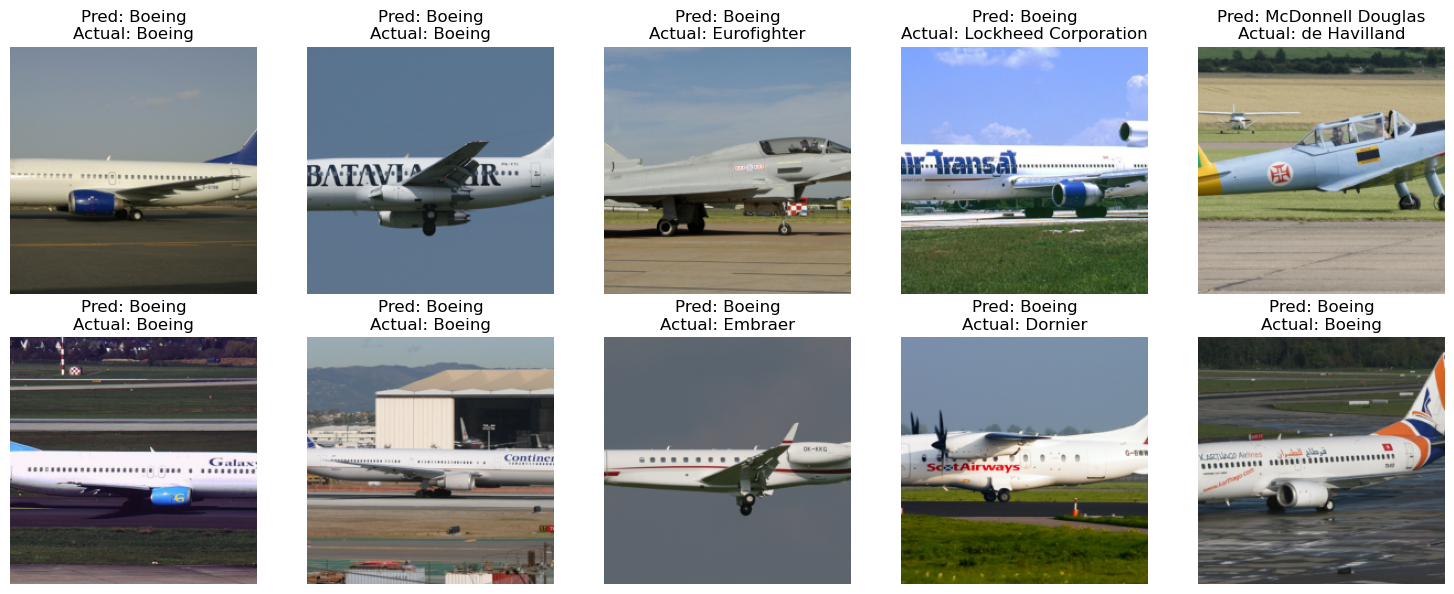

In [34]:
visualize_predictions(model, test_dataset)

In [35]:
#For grayscale mean = 0.5, std = 0.5
#img = img / 2 + 0.5  # unnormalize 


def unnormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

def matplotlib_imshow(img, one_channel=False, mean=None, std=None):
    if one_channel:
        img = img.mean(dim=0)
        npimg = img.numpy()
        plt.imshow(npimg, cmap="Greys")
    else:
        if mean is not None and std is not None:
            img = unnormalize(img, mean, std)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)).clip(0, 1))


# def matplotlib_imshow(img, one_channel=False):
#     if one_channel:
#         img = img.mean(dim=0)
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     if one_channel:
#         plt.imshow(npimg, cmap="Greys")
#     else:
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [36]:


# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fgvc_aircraft')

NameError: name 'SummaryWriter' is not defined

NameError: name 'writer' is not defined

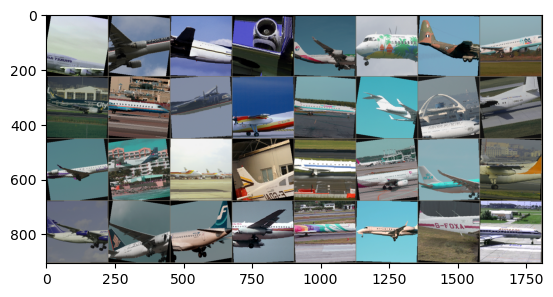

In [37]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
#matplotlib_imshow(img_grid, one_channel=False)
matplotlib_imshow(img_grid, one_channel=False, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])



# write to tensorboard
writer.add_image('four_fgvc_aircraft', img_grid, 0)

In [41]:
!tensorboard --logdir=runs

^C


In [ ]:
#from the command line and then navigating to http://localhost:6006 should show the following.

In [43]:
#writer.add_graph(model, images)
writer.close()

In [38]:
num_classes

30

In [39]:
train_dataset.label_map

{'Piper': 0,
 'Bombardier Aerospace': 1,
 'Gulfstream Aerospace': 2,
 'Boeing': 3,
 'Cirrus Aircraft': 4,
 'Embraer': 5,
 'Antonov': 6,
 'Airbus': 7,
 'Beechcraft': 8,
 'Ilyushin': 9,
 'Douglas Aircraft Company': 10,
 'Tupolev': 11,
 'Canadair': 12,
 'Eurofighter': 13,
 'Fokker': 14,
 'Saab': 15,
 'Dornier': 16,
 'Cessna': 17,
 'de Havilland': 18,
 'ATR': 19,
 'Fairchild': 20,
 'Dassault Aviation': 21,
 'Lockheed Martin': 22,
 'British Aerospace': 23,
 'Robin': 24,
 'Lockheed Corporation': 25,
 'Panavia': 26,
 'Yakovlev': 27,
 'Supermarine': 28,
 'McDonnell Douglas': 29}

In [40]:


def plot_confusion_matrix(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # <-- This line was missing
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



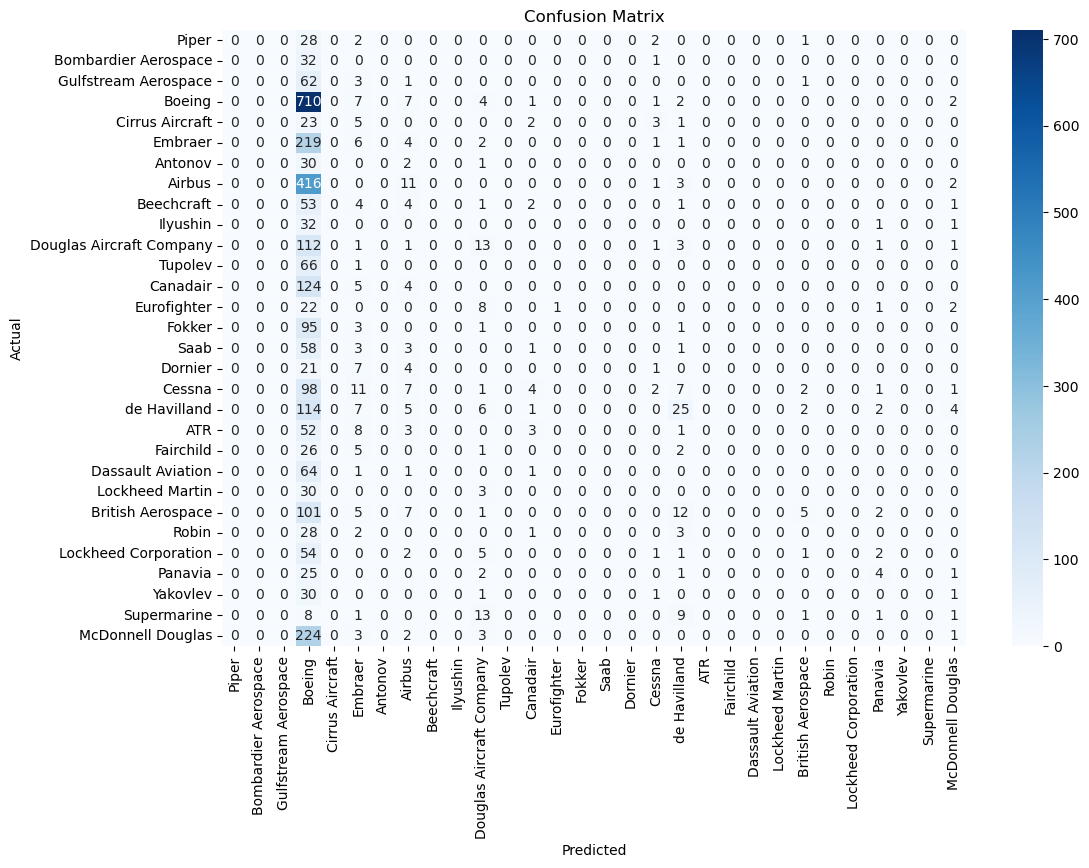

In [43]:
class_names = list(test_dataset.label_map.keys())  # or sorted list of manufacturer names
plot_confusion_matrix(model, test_loader, class_names)


In [44]:


vgg16 = vgg16(weights=VGG16_Weights.DEFAULT) #DEFAULT IMAGENET1K_V2


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\chihp/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 100MB/s]  


In [45]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [46]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 30)  # 30 = number of manufacturer classes
)

In [47]:
vgg16 = vgg16.to(device)

In [48]:
%%time
# Train the model, 10 epochs takes 9min.
train_model(vgg16, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1
-------------------------------
Single Batch Loss: 109.309540  [   32/ 3334]
Single Batch Loss: 109.500183  [ 3232/ 3334]
Epoch 1/10, Average Train Loss: 0.0328


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 2
-------------------------------
Single Batch Loss: 108.947945  [   32/ 3334]
Single Batch Loss: 111.744461  [ 3232/ 3334]
Epoch 2/10, Average Train Loss: 0.0335


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 3
-------------------------------
Single Batch Loss: 109.471542  [   32/ 3334]
Single Batch Loss: 111.214806  [ 3232/ 3334]
Epoch 3/10, Average Train Loss: 0.0334


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 4
-------------------------------
Single Batch Loss: 109.769180  [   32/ 3334]
Single Batch Loss: 110.244606  [ 3232/ 3334]
Epoch 4/10, Average Train Loss: 0.0331


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 5
-------------------------------
Single Batch Loss: 110.929413  [   32/ 3334]
Single Batch Loss: 109.167953  [ 3232/ 3334]
Epoch 5/10, Average Train Loss: 0.0327


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 6
-------------------------------
Single Batch Loss: 108.990318  [   32/ 3334]
Single Batch Loss: 110.776588  [ 3232/ 3334]
Epoch 6/10, Average Train Loss: 0.0332


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 7
-------------------------------
Single Batch Loss: 109.168503  [   32/ 3334]
Single Batch Loss: 109.420090  [ 3232/ 3334]
Epoch 7/10, Average Train Loss: 0.0328


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 8
-------------------------------
Single Batch Loss: 109.159271  [   32/ 3334]
Single Batch Loss: 108.768143  [ 3232/ 3334]
Epoch 8/10, Average Train Loss: 0.0326


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 9
-------------------------------
Single Batch Loss: 109.561859  [   32/ 3334]
Single Batch Loss: 108.505142  [ 3232/ 3334]
Epoch 9/10, Average Train Loss: 0.0325


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Epoch 10
-------------------------------
Single Batch Loss: 109.271339  [   32/ 3334]
Single Batch Loss: 108.678619  [ 3232/ 3334]
Epoch 10/10, Average Train Loss: 0.0326
Test Error: 
 Average Validation/ Test Loss: 
 107.6952 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0968, Recall: 0.0312, F1 Score: 0.0354
Done!
CPU times: total: 40min 4s
Wall time: 37min 42s


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
%%time
# Evaluate on test set
evaluate_model(vgg16, test_loader, criterion)

Test Error: 
 Average Validation/ Test Loss: 
 107.7502 
 Accuracy: 3.1% 
 Accuracy: 0.0312, Precision: 0.0800, Recall: 0.0312, F1 Score: 0.0345
CPU times: total: 2min 1s
Wall time: 1min 56s


C:\Users\chihp\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


107.75023669061207

In [ ]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

In [53]:
val_ImageNet = datasets.ImageNet(
    root='ImageNet',
    split='val',
    transform=transform_val_test
)

In [54]:
train_ImageNet = datasets.ImageNet(
    root='ImageNet',
    split='train',
    transform=transform_train
)

In [55]:
loader = DataLoader(train_ImageNet, batch_size=64, shuffle=True)

In [56]:
for X, y in loader:
    print(X.shape)
    print(y)
    break

torch.Size([64, 3, 224, 224])
tensor([263, 631,  25, 339, 191,  95, 118, 774, 550, 767, 389, 232, 283, 128,
        828, 452, 995, 217, 714, 293, 338, 768, 687, 210, 128,  60, 652, 924,
        851, 799, 345,  87, 764,  23, 703, 405, 955, 609, 496,  30, 633, 793,
        126,  13, 452, 319, 992, 465, 783, 432, 743, 900, 588, 384, 583, 170,
        416, 427, 708, 949, 860, 587, 854, 921])
